<a href="https://colab.research.google.com/github/Visweshvar-Axel/comment-sentiment-analysis-model/blob/main/sys_senti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install pandas

In [5]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.7 MB/s eta 0:00:00


In [6]:

import pandas as pd

# Try reading the CSV file with different encodings
encodings = ['utf-8', 'latin1', 'ISO-8859-1']
for encoding in encodings:
    try:
        df = pd.read_csv('/content/train.csv', sep=',', encoding=encoding)
        break  # If successful, break out of the loop
    except UnicodeDecodeError:
        pass  # If decoding fails, try the next encoding

# Select only the "text" and "sentiment" columns
df = df[["sentiment", "text"]]

# Display the first few rows
#df.head()


#independent features
x = list(df["text"])
y = list(df["sentiment"])

#y

# Create a mapping dictionary
sentiment_mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

# Map the "sentiment" column using the mapping dictionary
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

# Display the first few rows
#df.head()

y = list(df["sentiment"])
#y

# Now, make sure x contains the list of text samples
x = list(df["text"])
y = list(df["sentiment"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

#y_train

from transformers import DistilBertTokenizerFast
import torch

# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Convert your data into a list of strings or tuples of strings
X_train = [item if isinstance(item, str) else ' '.join(item) if isinstance(item, (list, tuple)) else str(item) for item in X_train]
X_test = [item if isinstance(item, str) else ' '.join(item) if isinstance(item, (list, tuple)) else str(item) for item in X_test]

# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt', max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt', max_length=512)


#train_encodings

import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

#train_dataset

from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
#SequenceClassification

# Define the number of labels in your dataset
num_labels = 3  # Since you have 0, 1 and 2

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for the learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps=500,                  # set a specific number of steps for evaluation
)

# Load the DistilBERT model with the updated number of labels
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# Define a function for computing metrics
def compute_metrics(p):
    # If predictions are logits (output from model before softmax)
    if isinstance(p.predictions, np.ndarray):
        predicted_labels = np.argmax(p.predictions, axis=1)
    # If predictions are already probabilities (output from model after softmax)
    elif isinstance(p.predictions, list) and len(p.predictions) > 0 and isinstance(p.predictions[0], np.ndarray):
        predicted_labels = np.argmax(p.predictions[0], axis=1)
    else:
        raise ValueError("Unknown format for predictions")

    # Ensure the label_ids and predicted_labels have compatible shapes
    y_true = p.label_ids
    assert y_true.shape == predicted_labels.shape, "Shapes of y_true and predicted_labels do not match."

    # Compute accuracy
    accuracy = np.mean(y_true == predicted_labels)

    return {"accuracy": accuracy}


# Create and train the trainer
trainer = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

import numpy as np

trainer.evaluate(test_dataset)

trainer.predict(test_dataset)

trainer.predict(test_dataset)[1]

trainer.predict(test_dataset)[1].shape

output=trainer.predict(test_dataset)[1]


# confusion matrix
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,output)
cm

#saving
trainer.save_model('senti_model')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [9]:
#saving
#trainer.save_model('senti_model')
model.save_pretrained('senti_model')
tokenizer.save_pretrained('senti_model')

('senti_model/tokenizer_config.json',
 'senti_model/special_tokens_map.json',
 'senti_model/vocab.txt',
 'senti_model/added_tokens.json',
 'senti_model/tokenizer.json')

In [17]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf

# Load your trained model and tokenizer
model = TFDistilBertForSequenceClassification.from_pretrained('senti_model')
tokenizer = DistilBertTokenizer.from_pretrained('senti_model')

# Define a function to perform sentiment analysis
def analyze_sentiment(comment):
    # Tokenize the comment
    inputs = tokenizer(comment, padding=True, truncation=True, return_tensors="tf")

    # Predict the sentiment label
    with tf.device('/device:GPU:0'):  # Use GPU for inference if available
        outputs = model(**inputs)

    # Get the predicted label
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]

    return predicted_label

# Example comments
comments = [
    "This is a positive comment.",
    "This is a negative comment.",
    "This is a neutral comment."
]

# Perform sentiment analysis for each comment
for comment in comments:
    predicted_sentiment = analyze_sentiment(comment)
    if predicted_sentiment == 0:
        sentiment = "Negative"
    elif predicted_sentiment == 1:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"
    print(f"Comment: '{comment}'\nPredicted Sentiment: {sentiment}\n")


Some layers from the model checkpoint at senti_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at senti_model and are newly initialized: ['dropout_199']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Comment: 'sreeja is a good girl.'
Predicted Sentiment: Positive

Comment: 'This is a negative comment.'
Predicted Sentiment: Negative

Comment: 'This is a neutral comment.'
Predicted Sentiment: Neutral



In [68]:
import plotly.express as px
import pandas as pd

# Your code to analyze sentiment (as provided)

comments = [
#    "This is a positive comment.",
#    "This is a negative comment.",
#    "This is a neutral comment.",
    "I'm so happy with this.",
"I appreciate your efforts.",
"I'm so happy with this.",
"This is terrible.",
"I appreciate your efforts.",
"Awesome work.",
"Terrible service.",
"Great job!",
"Waste of money.",
"Not bad, not great.",
"I'm so happy with this.",
"Highly recommended.",
"Brilliant!",
"Awesome work.",
"I love this product.",
"Excellent service.",
"I hate this product.",
"I love this product.",
"Middle of the road.",
"Fantastic!",
"Excellent service.",
"Excellent service.",
"This is amazing!",
"Not good at all.",
"This is amazing!",
"I'm so happy with this.",
"Neutral.",
"Highly recommended.",
"Disappointing.",
"Excellent service.",
"Waste of money.",
"Not good at all.",
"Great job!",
"It's okay.",
"This is amazing!",
"Not good at all.",
"Highly recommended.",
"Would not recommend.",
"This is amazing!",
"Fantastic!",
"Excellent service.",
"Excellent service.",
"Highly recommended.",
"This is amazing!",
"I appreciate your efforts.",
"Waste of money.",
"This is amazing!",
"Meh.",
"I'm so happy with this.",
"I'm very disappointed.",
"Disappointing.",
"Brilliant!",
"Brilliant!",
"This is amazing!",
"Neutral.",
"I love this product.",
"I love this product.",
"Disappointing.",
"Would not recommend.",
"I'm very disappointed.",
"Fantastic!",
"Poor quality.",
"Would not recommend.",
"Great job!",
"I'm so happy with this.",
"Great job!",
"It's okay.",
"Awful experience.",
"I appreciate your efforts.",
"I appreciate your efforts.",
"I love this product.",
"I hate this product.",
"I appreciate your efforts.",
"I'm so happy with this.",
"Disappointing.",
"I appreciate your efforts.",
"Brilliant!",
"No strong feelings.",
"Poor quality.",
"I'm very disappointed.",
"Awful experience.",
"I'm so happy with this.",
"I'm very disappointed.",
"Fantastic!",
"I'm very disappointed.",
"Excellent service.",
"This is terrible.",
"Middle of the road.",
"I'm very disappointed.",
"Awesome work.",
"Highly recommended.",
"Poor quality.",
"Brilliant!",
"This is amazing!",
"Not bad, not great.",
"Great job!",
"Awesome work.",
"Brilliant!",
"Awesome work.",
"Not good at all.",
"Gowtham is awesome",
]

results = {'Positive': 0, 'Neutral': 0, 'Negative': 0}

# Perform sentiment analysis for each comment and accumulate the results
for comment in comments:
    predicted_sentiment = analyze_sentiment(comment)
    if predicted_sentiment == 0:
        results['Negative'] += 1
    elif predicted_sentiment == 1:
        results['Neutral'] += 1
    else:
        results['Positive'] += 1

# Calculate percentages
total = len(comments)
percentages = {key: value / total * 100 for key, value in results.items()}

# Create a DataFrame for Plotly
df = pd.DataFrame({'Sentiment': percentages.keys(), 'Percentage': percentages.values()})

# Create a bar chart using Plotly
fig = px.bar(df, x='Sentiment', y='Percentage', text='Percentage', title='Sentiment Analysis Results')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()


In [69]:
import plotly.express as px
import pandas as pd

# Your code to analyze sentiment (as provided)

comments = [
  #  "This is a positive comment.",
  #  "This is a negative comment.",
  #  "This is a neutral comment.",
    "I'm so happy with this.",
"I appreciate your efforts.",
"I'm so happy with this.",
"This is terrible.",
"I appreciate your efforts.",
"Awesome work.",
"Terrible service.",
"Great job!",
"Waste of money.",
"Not bad, not great.",
"I'm so happy with this.",
"Highly recommended.",
"Brilliant!",
"Awesome work.",
"I love this product.",
"Excellent service.",
"I hate this product.",
"I love this product.",
"Middle of the road.",
"Fantastic!",
"Excellent service.",
"Excellent service.",
"This is amazing!",
"Not good at all.",
"This is amazing!",
"I'm so happy with this.",
"Neutral.",
"Highly recommended.",
"Disappointing.",
"Excellent service.",
"Waste of money.",
"Not good at all.",
"Great job!",
"It's okay.",
"This is amazing!",
"Not good at all.",
"Highly recommended.",
"Would not recommend.",
"This is amazing!",
"Fantastic!",
"Excellent service.",
"Excellent service.",
"Highly recommended.",
"This is amazing!",
"I appreciate your efforts.",
"Waste of money.",
"This is amazing!",
"Meh.",
"I'm so happy with this.",
"I'm very disappointed.",
"Disappointing.",
"Brilliant!",
"Brilliant!",
"This is amazing!",
"Neutral.",
"I love this product.",
"I love this product.",
"Disappointing.",
"Would not recommend.",
"I'm very disappointed.",
"Fantastic!",
"Poor quality.",
"Would not recommend.",
"Great job!",
"I'm so happy with this.",
"Great job!",
"It's okay.",
"Awful experience.",
"I appreciate your efforts.",
"I appreciate your efforts.",
"I love this product.",
"I hate this product.",
"I appreciate your efforts.",
"I'm so happy with this.",
"Disappointing.",
"I appreciate your efforts.",
"Brilliant!",
"No strong feelings.",
"Poor quality.",
"I'm very disappointed.",
"Awful experience.",
"I'm so happy with this.",
"I'm very disappointed.",
"Fantastic!",
"I'm very disappointed.",
"Excellent service.",
"This is terrible.",
"Middle of the road.",
"I'm very disappointed.",
"Awesome work.",
"Highly recommended.",
"Poor quality.",
"Brilliant!",
"This is amazing!",
"Not bad, not great.",
"Great job!",
"Awesome work.",
"Brilliant!",
"Awesome work.",
"Not good at all.",
"Gowtham is awesome",
]

results = {'Positive': 0, 'Neutral': 0, 'Negative': 0}

# Perform sentiment analysis for each comment and accumulate the results
for comment in comments:
    predicted_sentiment = analyze_sentiment(comment)
    if predicted_sentiment == 0:
        results['Negative'] += 1
    elif predicted_sentiment == 1:
        results['Neutral'] += 1
    else:
        results['Positive'] += 1

# Calculate percentages
total = len(comments)
percentages = {key: value / total * 100 for key, value in results.items()}

# Create a DataFrame for Plotly
df = pd.DataFrame({'Sentiment': percentages.keys(), 'Percentage': percentages.values()})

# Define custom colors
custom_colors = ['#11aa74', '#dd3511', '#1144cc']  # Replace these with your desired colors
# '#00CC96', '#FF5733', '#3366FF'
# '#00aa74', '#dd3511', '#3366FF'

# Create a donut chart using Plotly with custom colors
fig = px.pie(df, values='Percentage', names='Sentiment', title='Sentiment Analysis Results', hole=0.4,
             color_discrete_sequence=custom_colors)

fig.update_traces(textinfo='percent+label')
fig.show()


In [70]:
import plotly.express as px

# Sentiment percentages
percentages = {
    "Negative": 20,
    "Neutral": 50,
    "Positive": 30
}

# Create a figure
fig = px.pie(
    values=list(percentages.values()),
    names=list(percentages.keys()),
    hole=0.4,
)

# Update the layout for a 3D-like appearance
fig.update_traces(textinfo='percent+label')
fig.update_layout(title='Sentiment Analysis Results (3D-like Donut Chart)')

# Show the chart
fig.show()


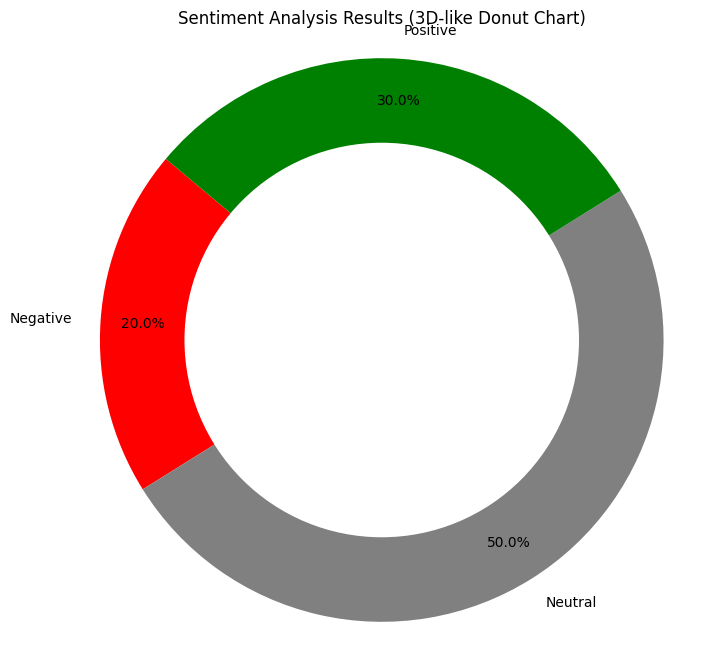

In [71]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

# Sentiment percentages
percentages = {
    "Negative": 20,
    "Neutral": 50,
    "Positive": 30
}

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'gray', 'green']
labels = percentages.keys()

# Convert percentages to degrees
sizes = [p / 100 * 360 for p in percentages.values()]

# Create the 2D pie chart
ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# Create a circle for the donut effect
center_circle = Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

# Set equal aspect ratio to ensure that pie is drawn as a circle.
ax.axis('equal')

plt.title("Sentiment Analysis Results (3D-like Donut Chart)")

plt.show()


In [86]:
import plotly.express as px
import pandas as pd

# Your code to analyze sentiment (as provided)

comments = [
   "This is a positive comment.",
   "This is a negative comment.",
   "This is a neutral comment.",
]
results = {'Positive': 0, 'Neutral': 0, 'Negative': 0}

# Perform sentiment analysis for each comment and accumulate the results
for comment in comments:
    predicted_sentiment = analyze_sentiment(comment)
    if predicted_sentiment == 0:
        results['Negative'] += 1
    elif predicted_sentiment == 1:
        results['Neutral'] += 1
    else:
        results['Positive'] += 1

# Calculate percentages
total = len(comments)
percentages = {key: value / total * 100 for key, value in results.items()}

# Create a DataFrame for Plotly
df = pd.DataFrame({'Sentiment': percentages.keys(), 'Percentage': percentages.values()})

# Define custom colors
custom_colors = ['#EF553B', '#636EFA', '#00CC96']

# Create an animated donut chart using Plotly
fig = px.pie(df, values='Percentage', names='Sentiment', title='Sentiment Analysis Results',
             hole=0.4, color_discrete_sequence=custom_colors)  # Set hole to create a donut chart

fig.update_traces(textinfo='percent+label')
fig.show()


In [77]:
pip install mayavi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.9/268.9 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 118.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 95.8 MB/s eta 0:00:00
  Using cached vtk-9.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (79.3 MB)
  Created wheel for mayavi: filename=mayavi-4.8.1-cp310-cp310-linux_x86_64.whl size=16167222 sha256=664253f8e88870c4c73da1c7c4b1a3585733641e4cb14604311a7926c5ab750a
  Stored in directory: /root/.cache/pip/wheels/c2/6b/23/49aa8ae5063a76fbc35ce90e74f8361cddb9d3a86d5a41ec0a
Successfully b

In [89]:
import plotly.express as px

# Sample 3D data
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width', color='species')

# Show the interactive 3D plot
fig.show()


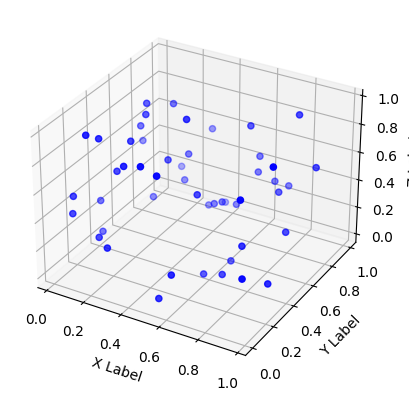

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure()

# Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Sample 3D data
x = np.random.rand(50)
y = np.random.rand(50)
z = np.random.rand(50)

# Create a 3D scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()


In [ ]:
model_loaded = pickle.load(open('/content/model.pkl','rb'))